# Channel Head Coupling Analysis - Experiment Template

This notebook provides a clean template for running analysis experiments with different parameters.

**Key features:**
- All experiment parameters defined in one cell
- Outputs automatically organized by experiment name/threshold
- Easy to duplicate for new experiments

## How to use:
1. **Duplicate this notebook** for each experiment (e.g., `experiment_th500.ipynb`)
2. **Modify the parameters** in the "Experiment Configuration" cell below
3. **Run all cells** to execute the analysis
4. Results are saved to `data/outputs/experiments/{EXPERIMENT_NAME}/`

---
## Experiment Configuration

**Modify these parameters for your experiment:**

In [1]:
# ============================================================================
# EXPERIMENT PARAMETERS - MODIFY THESE FOR YOUR EXPERIMENT
# ============================================================================

# Experiment identification
EXPERIMENT_NAME = "th250_test"  # Unique name for this experiment
EXPERIMENT_NOTES = "Testing higher stream threshold (250 vs default 145)"

# Stream extraction threshold (default in paper: 145)
# Higher = fewer, larger streams; Lower = more, smaller streams
STREAM_THRESHOLD = 250

# Basins to analyze (set to None for all 18 basins)
# Examples:
#   BASINS_TO_RUN = None  # All 18 basins
#   BASINS_TO_RUN = ["inyo", "humboldt"]  # Just these two
#   BASINS_TO_RUN = ["inyo"]  # Single basin for quick test
BASINS_TO_RUN = None    # All 18 basins

# Limit outlets per basin (None = all outlets, useful for quick tests)
MAX_OUTLETS_PER_BASIN = None

# Connectivity for coupling detection (4 or 8)
# 8 = include diagonal neighbors (more sensitive)
# 4 = only cardinal directions (more conservative)
CONNECTIVITY = 8

# ============================================================================
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Notes: {EXPERIMENT_NOTES}")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print(f"Basins: {BASINS_TO_RUN or 'All 18'}")
print(f"Max outlets per basin: {MAX_OUTLETS_PER_BASIN or 'All'}")
print(f"Connectivity: {CONNECTIVITY}")

Experiment: th250_test
Notes: Testing higher stream threshold (250 vs default 145)
Stream threshold: 250
Basins: All 18
Max outlets per basin: All
Connectivity: 8


---
## Setup and Imports

In [2]:
import sys
import pathlib
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import topotoolbox as tt3

# Add project root so "channel_heads" package is visible
project_root = pathlib.Path("/Users/guypi/Projects/channel-heads")
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Core analysis imports
from channel_heads import (
    CouplingAnalyzer,
    first_meet_pairs_for_outlet,
    outlet_node_ids_from_streampoi,
    # Lengthwise asymmetry
    LengthwiseAsymmetryAnalyzer,
    compute_asymmetry_statistics,
    merge_coupling_and_asymmetry,
    # Basin configuration
    get_z_th,
    get_basin_config,
    get_reference_delta_L,
    BASIN_CONFIG,
    # Path management
    CROPPED_DEMS_DIR,
    get_experiment_output_dir,
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
%matplotlib inline

# Create output directory for this experiment
OUTPUT_DIR = get_experiment_output_dir(EXPERIMENT_NAME)
print(f"\nOutput directory: {OUTPUT_DIR}")
print("Setup complete!")


Output directory: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th250_test
Setup complete!


---
## Basin Configuration

In [3]:
# All 18 basins from Goren & Shelef (2024)
ALL_BASINS = {
    "inyo": {"dem_path": CROPPED_DEMS_DIR / "Inyo_strm_crop.tif", "paper_name": "inyo"},
    "humboldt": {"dem_path": CROPPED_DEMS_DIR / "Humboldt_strm_crop.tif", "paper_name": "humboldt"},
    "calnalpine": {"dem_path": CROPPED_DEMS_DIR / "CalnAlpine_strm_crop.tif", "paper_name": "clanalpine"},
    "daqing": {"dem_path": CROPPED_DEMS_DIR / "Daqing_strm_crop.tif", "paper_name": "daqing"},
    "kammanasie": {"dem_path": CROPPED_DEMS_DIR / "Kammanasie_strm_crop.tif", "paper_name": "kammanassie"},
    "luliang": {"dem_path": CROPPED_DEMS_DIR / "Luliang_strm_crop.tif", "paper_name": "luliang"},
    "finisterre": {"dem_path": CROPPED_DEMS_DIR / "Finisterre_strm_crop.tif", "paper_name": "finisterre"},
    "taiwan": {"dem_path": CROPPED_DEMS_DIR / "Taiwan_strm_crop.tif", "paper_name": "taiwan"},
    "panamint": {"dem_path": CROPPED_DEMS_DIR / "Panamint_strm_crop.tif", "paper_name": "panamint"},
    "sakhalin": {"dem_path": CROPPED_DEMS_DIR / "Sakhalin_strm_crop.tif", "paper_name": "sakhalin"},
    "vallefertil": {"dem_path": CROPPED_DEMS_DIR / "ValleFertil_strm_crop.tif", "paper_name": "vallefertil"},
    "sierramadre": {"dem_path": CROPPED_DEMS_DIR / "SierraMadre_strm_crop.tif", "paper_name": "sierramadre"},
    "sierranevadaspain": {"dem_path": CROPPED_DEMS_DIR / "SierraNevadaSpain_strm_crop.tif", "paper_name": "sierranevada_spain"},
    "piedepalo": {"dem_path": CROPPED_DEMS_DIR / "PieDePalo_strm_crop.tif", "paper_name": "piedepalo"},
    "toano": {"dem_path": CROPPED_DEMS_DIR / "Toano_strm_crop.tif", "paper_name": "toano"},
    "troodos": {"dem_path": CROPPED_DEMS_DIR / "Troodos_strm_crop.tif", "paper_name": "troodos"},
    "tsugaru": {"dem_path": CROPPED_DEMS_DIR / "Tsugaru_strm_crop.tif", "paper_name": "tsugaru"},
    "yoro": {"dem_path": CROPPED_DEMS_DIR / "Yoro_strm_crop.tif", "paper_name": "yoro"},
}

# Filter to selected basins
if BASINS_TO_RUN is not None:
    BASINS_TO_ANALYZE = {k: v for k, v in ALL_BASINS.items() if k in BASINS_TO_RUN}
else:
    BASINS_TO_ANALYZE = ALL_BASINS

# Show basin configurations
print("=" * 80)
print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print(f"Basins to analyze: {len(BASINS_TO_ANALYZE)}")
print("=" * 80)

for name, config in BASINS_TO_ANALYZE.items():
    basin_config = get_basin_config(config["paper_name"])
    dem_exists = config['dem_path'].exists()
    status = "OK" if dem_exists else "MISSING"
    print(f"  {basin_config['full_name'][:40]:<40} z_th={basin_config['z_th']:>4}m [{status}]")

Experiment: th250_test
Stream threshold: 250
Basins to analyze: 18
  Inyo Mountains, California               z_th=1200m [OK]
  Humboldt Range, Nevada                   z_th=1450m [OK]
  Clan Alpine Mountains, Nevada            z_th=1700m [OK]
  Daquing Shan, China                      z_th=1200m [OK]
  Kammanassie Mountains, South Africa      z_th= 630m [OK]
  Lüliang Mountains, China                 z_th=1100m [OK]
  Finisterre Range, Papua New Guinea       z_th= 400m [OK]
  Central Mountain Range, Taiwan           z_th=  80m [OK]
  Panamint Range, California               z_th= 800m [OK]
  Sakhalin Mountains, Russia               z_th=  60m [OK]
  Sierra del Valle Fértil, Argentina       z_th=1050m [MISSING]
  Sierra Madre del Sur, Mexico             z_th= 380m [OK]
  Sierra Nevada, Spain                     z_th=1200m [OK]
  Sierra Pie de Palo, Argentina            z_th= 650m [MISSING]
  Toano Range, Nevada                      z_th=1710m [OK]
  Troodos Mountains, Cyprus           

---
## Analysis Functions

In [4]:
def load_and_prepare_basin(basin_name, dem_path, z_th, stream_threshold):
    """Load DEM, apply z_th mask, and create stream network."""
    print(f"Loading {basin_name}...")
    
    # Load DEM
    dem = tt3.read_tif(str(dem_path))
    print(f"  DEM shape: {dem.z.shape}")
    print(f"  Elevation range: {np.nanmin(dem.z):.0f} - {np.nanmax(dem.z):.0f} m")
    
    # Apply z_th mask
    dem.z[dem.z < z_th] = np.nan
    valid_pct = 100 * np.sum(~np.isnan(dem.z)) / dem.z.size
    print(f"  Applied z_th={z_th} m mask: {valid_pct:.1f}% valid pixels")
    
    # Create flow and stream objects
    fd = tt3.FlowObject(dem)
    s = tt3.StreamObject(fd, threshold=stream_threshold)
    
    # Count network features
    n_outlets = np.sum(s.streampoi('outlets'))
    n_heads = np.sum(s.streampoi('channelheads'))
    n_confluences = np.sum(s.streampoi('confluences'))
    print(f"  Stream network (threshold={stream_threshold}):")
    print(f"    Outlets: {n_outlets}, Heads: {n_heads}, Confluences: {n_confluences}")
    
    return {"dem": dem, "fd": fd, "s": s}


def run_full_analysis(s, fd, dem, lat, connectivity, max_outlets=None):
    """Run coupling + lengthwise asymmetry analysis for all outlets."""
    outlets = outlet_node_ids_from_streampoi(s)
    outlets = [int(o) for o in outlets]
    
    if max_outlets and len(outlets) > max_outlets:
        print(f"  Limiting to first {max_outlets} outlets (of {len(outlets)})")
        outlets = outlets[:max_outlets]
    
    # Create analyzers
    coupling_an = CouplingAnalyzer(fd, s, dem, connectivity=connectivity)
    asymmetry_an = LengthwiseAsymmetryAnalyzer(s, dem, lat=lat)
    
    coupling_dfs = []
    asymmetry_dfs = []
    
    for idx, outlet in enumerate(outlets, 1):
        print(f"  [{idx}/{len(outlets)}] outlet={outlet}", end="", flush=True)
        
        pairs_at_confluence, basin_heads = first_meet_pairs_for_outlet(s, outlet)
        
        if not pairs_at_confluence:
            print(" (no pairs)")
            continue
        
        # Clear caches between outlets
        coupling_an.clear_cache()
        asymmetry_an.clear_cache()
        
        df_coupling = coupling_an.evaluate_pairs_for_outlet(outlet, pairs_at_confluence)
        df_asymmetry = asymmetry_an.evaluate_pairs_for_outlet(outlet, pairs_at_confluence)
        
        n_pairs = len(df_coupling)
        n_touching = df_coupling['touching'].sum() if not df_coupling.empty else 0
        print(f" ({n_pairs} pairs, {n_touching} touching)")
        
        if not df_coupling.empty:
            coupling_dfs.append(df_coupling)
        if not df_asymmetry.empty:
            asymmetry_dfs.append(df_asymmetry)
    
    if not coupling_dfs:
        return pd.DataFrame()
    
    df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)
    df_asymmetry_all = pd.concat(asymmetry_dfs, ignore_index=True)
    df_combined = merge_coupling_and_asymmetry(df_coupling_all, df_asymmetry_all)
    df_combined.sort_values(["outlet", "confluence", "head_1", "head_2"], inplace=True, ignore_index=True)
    
    return df_combined

---
## Run Analysis

In [5]:
# Store results
basin_results = {}
basin_data = {}

# Save experiment metadata
metadata = {
    "experiment_name": EXPERIMENT_NAME,
    "experiment_notes": EXPERIMENT_NOTES,
    "stream_threshold": STREAM_THRESHOLD,
    "connectivity": CONNECTIVITY,
    "max_outlets_per_basin": MAX_OUTLETS_PER_BASIN,
    "basins": list(BASINS_TO_ANALYZE.keys()),
    "timestamp": datetime.now().isoformat(),
}

import json
with open(OUTPUT_DIR / "experiment_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
print(f"Saved experiment metadata to: {OUTPUT_DIR / 'experiment_metadata.json'}")

print("\n" + "=" * 80)

for basin_name, config in BASINS_TO_ANALYZE.items():
    if not config["dem_path"].exists():
        print(f"\nSkipping {basin_name}: DEM not found")
        continue
    
    print("\n" + "=" * 80)
    print(f"Processing: {basin_name.upper()}")
    print("=" * 80)
    
    basin_config = get_basin_config(config["paper_name"])
    z_th = basin_config["z_th"]
    lat = basin_config["lat"]
    
    # Load and prepare
    data = load_and_prepare_basin(
        basin_name=basin_name,
        dem_path=config["dem_path"],
        z_th=z_th,
        stream_threshold=STREAM_THRESHOLD,
    )
    basin_data[basin_name] = data
    
    # Run analysis
    print(f"\nRunning analysis (connectivity={CONNECTIVITY})...")
    df_results = run_full_analysis(
        s=data["s"],
        fd=data["fd"],
        dem=data["dem"],
        lat=lat,
        connectivity=CONNECTIVITY,
        max_outlets=MAX_OUTLETS_PER_BASIN,
    )
    basin_results[basin_name] = df_results
    
    # Save per-basin results
    output_path = OUTPUT_DIR / f"{basin_name}_results.csv"
    df_results.to_csv(output_path, index=False)
    print(f"Saved: {output_path}")

print("\n" + "=" * 80)
print(f"Analysis complete! Results in: {OUTPUT_DIR}")
print("=" * 80)

Saved experiment metadata to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th250_test/experiment_metadata.json


Processing: INYO
Loading inyo...
  DEM shape: (289, 284)
  Elevation range: 329 - 3363 m
  Applied z_th=1200 m mask: 65.4% valid pixels
  Stream network (threshold=250):
    Outlets: 31, Heads: 57, Confluences: 26

Running analysis (connectivity=8)...
  [1/31] outlet=1 (1 pairs, 1 touching)
  [2/31] outlet=2 (no pairs)
  [3/31] outlet=3 (no pairs)
  [4/31] outlet=4 (no pairs)
  [5/31] outlet=5 (1 pairs, 1 touching)
  [6/31] outlet=6 (no pairs)
  [7/31] outlet=39 (no pairs)
  [8/31] outlet=80 (1 pairs, 1 touching)
  [9/31] outlet=141 (no pairs)
  [10/31] outlet=151 (no pairs)
  [11/31] outlet=249 (1 pairs, 1 touching)
  [12/31] outlet=301 (1 pairs, 0 touching)
  [13/31] outlet=353 (no pairs)
  [14/31] outlet=508 (1 pairs, 0 touching)
  [15/31] outlet=540 (no pairs)
  [16/31] outlet=570 (no pairs)
  [17/31] outlet=578 (1 pairs, 0 touching)
  [18/31] outlet=606 

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_69779/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (10 pairs, 3 touching)
  [31/41] outlet=1501 (no pairs)
  [32/41] outlet=1542 (no pairs)
  [33/41] outlet=1548 (no pairs)
  [34/41] outlet=1653 (no pairs)
  [35/41] outlet=1690 (1 pairs, 1 touching)
  [36/41] outlet=1802 (no pairs)
  [37/41] outlet=1928 (1 pairs, 0 touching)
  [38/41] outlet=2007 (1 pairs, 0 touching)
  [39/41] outlet=2032 (no pairs)
  [40/41] outlet=2033 (no pairs)
  [41/41] outlet=2034 (no pairs)
Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th250_test/kammanasie_results.csv

Processing: LULIANG
Loading luliang...
  DEM shape: (349, 756)
  Elevation range: 857 - 2397 m
  Applied z_th=1100 m mask: 55.8% valid pixels
  Stream network (threshold=250):
    Outlets: 85, Heads: 171, Confluences: 86

Running analysis (connectivity=8)...
  [1/85] outlet=0 (3 pairs, 0 touching)
  [2/85] outlet=60 (no pairs)
  [3/85] outlet=114 (no pairs)
  [4/85] outlet=134 (no pairs)
  [5/85] outlet=141 (no pairs)
  [6/85] outlet=167 (no pairs)
  [7/85] outlet=233 (6 p

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_69779/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (36 pairs, 3 touching)
  [16/85] outlet=563 (no pairs)
  [17/85] outlet=637 (no pairs)
  [18/85] outlet=675 (no pairs)
  [19/85] outlet=715 (no pairs)
  [20/85] outlet=823 (no pairs)
  [21/85] outlet=861 (15 pairs, 2 touching)
  [22/85] outlet=872 (no pairs)
  [23/85] outlet=949 (no pairs)
  [24/85] outlet=970 (no pairs)
  [25/85] outlet=1054 (no pairs)
  [26/85] outlet=1086 (no pairs)
  [27/85] outlet=1099 (no pairs)
  [28/85] outlet=1118 (no pairs)
  [29/85] outlet=1219 (no pairs)
  [30/85] outlet=1267 (no pairs)
  [31/85] outlet=1409 (no pairs)
  [32/85] outlet=1429 (21 pairs, 5 touching)
  [33/85] outlet=1455 (no pairs)
  [34/85] outlet=1484 (66 pairs, 5 touching)
  [35/85] outlet=1548 (no pairs)
  [36/85] outlet=1557 (no pairs)
  [37/85] outlet=1665 (no pairs)
  [38/85] outlet=1682 (10 pairs, 3 touching)
  [39/85] outlet=1781 (no pairs)
  [40/85] outlet=1909 (no pairs)
  [41/85] outlet=1939 (no pairs)
  [42/85] outlet=1965 (no pairs)
  [43/85] outlet=2038 (no pairs)
  [44/85] out

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_69779/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


  DEM shape: (2118, 1957)
  Elevation range: -28 - 3917 m
  Applied z_th=80 m mask: 60.4% valid pixels
  Stream network (threshold=250):
    Outlets: 292, Heads: 2628, Confluences: 2315

Running analysis (connectivity=8)...
  [1/292] outlet=0 (no pairs)
  [2/292] outlet=8 (no pairs)
  [3/292] outlet=10 (no pairs)
  [4/292] outlet=16 (no pairs)
  [5/292] outlet=35 (no pairs)
  [6/292] outlet=38 (no pairs)
  [7/292] outlet=46 (no pairs)
  [8/292] outlet=47 (no pairs)
  [9/292] outlet=48 (no pairs)
  [10/292] outlet=64 (no pairs)
  [11/292] outlet=65 (no pairs)
  [12/292] outlet=80 (no pairs)
  [13/292] outlet=86 (1 pairs, 0 touching)
  [14/292] outlet=106 (6 pairs, 3 touching)
  [15/292] outlet=108 (3 pairs, 2 touching)
  [16/292] outlet=129 (no pairs)
  [17/292] outlet=221 (no pairs)
  [18/292] outlet=230 (no pairs)
  [19/292] outlet=236 (1 pairs, 1 touching)
  [20/292] outlet=245 (6 pairs, 1 touching)
  [21/292] outlet=251 (no pairs)
  [22/292] outlet=259 (no pairs)
  [23/292] outlet=2

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_69779/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th250_test/taiwan_results.csv

Processing: PANAMINT
Loading panamint...
  DEM shape: (351, 393)
  Elevation range: 14 - 3344 m
  Applied z_th=800 m mask: 74.4% valid pixels
  Stream network (threshold=250):
    Outlets: 36, Heads: 100, Confluences: 64

Running analysis (connectivity=8)...
  [1/36] outlet=0 (no pairs)
  [2/36] outlet=1 (no pairs)
  [3/36] outlet=2 (253 pairs, 9 touching)
  [4/36] outlet=3 (no pairs)
  [5/36] outlet=29 (no pairs)
  [6/36] outlet=72 (no pairs)
  [7/36] outlet=170 (no pairs)
  [8/36] outlet=288 (3 pairs, 0 touching)
  [9/36] outlet=386 (no pairs)
  [10/36] outlet=417 (no pairs)
  [11/36] outlet=452 (no pairs)
  [12/36] outlet=476 (3 pairs, 1 touching)
  [13/36] outlet=526 (no pairs)
  [14/36] outlet=613 (36 pairs, 6 touching)
  [15/36] outlet=614 (no pairs)
  [16/36] outlet=631 (no pairs)
  [17/36] outlet=692 (28 pairs, 3 touching)
  [18/36] outlet=776 (no pairs)
  [19/36] outlet=1696 (no 

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_69779/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


  Stream network (threshold=250):
    Outlets: 310, Heads: 1690, Confluences: 1371

Running analysis (connectivity=8)...
  [1/310] outlet=0 (no pairs)
  [2/310] outlet=1 (no pairs)
  [3/310] outlet=2 (no pairs)
  [4/310] outlet=3 (no pairs)
  [5/310] outlet=7 (91 pairs, 8 touching)
  [6/310] outlet=8 (91 pairs, 7 touching)
  [7/310] outlet=9 (no pairs)
  [8/310] outlet=10 (36 pairs, 2 touching)
  [9/310] outlet=11 (no pairs)
  [10/310] outlet=12 (no pairs)
  [11/310] outlet=13 (no pairs)
  [12/310] outlet=15 (1 pairs, 0 touching)
  [13/310] outlet=16 (no pairs)
  [14/310] outlet=17 (1 pairs, 1 touching)
  [15/310] outlet=18 (1 pairs, 1 touching)
  [16/310] outlet=20 (10 pairs, 2 touching)
  [17/310] outlet=328 (no pairs)
  [18/310] outlet=339 (105 pairs, 6 touching)
  [19/310] outlet=374 (91 pairs, 8 touching)
  [20/310] outlet=644 (no pairs)
  [21/310] outlet=848 (no pairs)
  [22/310] outlet=1535 (no pairs)
  [23/310] outlet=1690 (no pairs)
  [24/310] outlet=1714 (no pairs)
  [25/310]

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_69779/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th250_test/sierramadre_results.csv

Processing: SIERRANEVADASPAIN
Loading sierranevadaspain...
  DEM shape: (266, 543)
  Elevation range: 527 - 3176 m
  Applied z_th=1200 m mask: 80.2% valid pixels
  Stream network (threshold=250):
    Outlets: 42, Heads: 112, Confluences: 68

Running analysis (connectivity=8)...
  [1/42] outlet=0 (1 pairs, 1 touching)
  [2/42] outlet=26 (36 pairs, 0 touching)
  [3/42] outlet=146 (no pairs)
  [4/42] outlet=230 (3 pairs, 2 touching)
  [5/42] outlet=415 (no pairs)
  [6/42] outlet=764 (no pairs)
  [7/42] outlet=838 (21 pairs, 3 touching)
  [8/42] outlet=1023 (1 pairs, 0 touching)
  [9/42] outlet=1071 (45 pairs, 4 touching)
  [10/42] outlet=1133 (10 pairs, 2 touching)
  [11/42] outlet=1205 (no pairs)
  [12/42] outlet=1399 (6 pairs, 1 touching)
  [13/42] outlet=1428 (no pairs)
  [14/42] outlet=1441 (no pairs)
  [15/42] outlet=1560 (no pairs)
  [16/42] outlet=1588 (1 pairs, 1 touching)
  [17

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_69779/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


 (no pairs)
  [23/43] outlet=346 (no pairs)
  [24/43] outlet=371 (1 pairs, 1 touching)
  [25/43] outlet=2271 (6 pairs, 2 touching)
  [26/43] outlet=2284 (no pairs)
  [27/43] outlet=2308 (1 pairs, 0 touching)
  [28/43] outlet=2468 (28 pairs, 5 touching)
  [29/43] outlet=2493 (10 pairs, 2 touching)
  [30/43] outlet=2511 (no pairs)
  [31/43] outlet=2523 (no pairs)
  [32/43] outlet=2548 (6 pairs, 1 touching)
  [33/43] outlet=2567 (no pairs)
  [34/43] outlet=2568 (no pairs)
  [35/43] outlet=2585 (no pairs)
  [36/43] outlet=2590 (no pairs)
  [37/43] outlet=2591 (no pairs)
  [38/43] outlet=2592 (no pairs)
  [39/43] outlet=2593 (3 pairs, 2 touching)
  [40/43] outlet=2594 (1 pairs, 0 touching)
  [41/43] outlet=2595 (no pairs)
  [42/43] outlet=2596 (no pairs)
  [43/43] outlet=2597 (no pairs)
Saved: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th250_test/toano_results.csv

Skipping troodos: DEM not found

Skipping tsugaru: DEM not found

Processing: YORO
Loading yoro...
  DEM shap

/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_69779/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)
/var/folders/lq/1mmlyt8d7kg0w5y404p0l8j80000gn/T/ipykernel_69779/2029960776.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_coupling_all = pd.concat(coupling_dfs, ignore_index=True)


---
## Results Summary

In [6]:
# Summary table
summary_rows = []

for basin_name, df in basin_results.items():
    if df.empty:
        continue
    
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    
    n_pairs = len(df)
    n_touching = df['touching'].sum()
    touch_pct = 100 * n_touching / n_pairs if n_pairs > 0 else 0
    delta_L_stats = compute_asymmetry_statistics(df['delta_L'].dropna())
    
    summary_rows.append({
        "Basin": config["full_name"].split(',')[0],
        "z_th (m)": config["z_th"],
        "Total Pairs": n_pairs,
        "Touching": n_touching,
        "Touch %": f"{touch_pct:.1f}%",
        "delta_L (median)": f"{delta_L_stats['median']:.3f}",
        "Reference delta_L": f"{ref['median']:.2f}",
    })

df_summary = pd.DataFrame(summary_rows)
print(f"\n=== Experiment: {EXPERIMENT_NAME} ===")
print(f"Stream threshold: {STREAM_THRESHOLD}")
print()
print(df_summary.to_string(index=False))

# Save summary
df_summary.to_csv(OUTPUT_DIR / "summary.csv", index=False)
print(f"\nSaved summary to: {OUTPUT_DIR / 'summary.csv'}")


=== Experiment: th250_test ===
Stream threshold: 250

                 Basin  z_th (m)  Total Pairs  Touching Touch % delta_L (median) Reference delta_L
        Inyo Mountains      1200           40        12   30.0%            1.063              0.17
        Humboldt Range      1450           46        18   39.1%            0.716              0.34
 Clan Alpine Mountains      1700           15         5   33.3%            0.571              0.27
          Daquing Shan      1200           41        13   31.7%            0.734              0.82
 Kammanassie Mountains       630           60        14   23.3%            0.985              0.35
     Lüliang Mountains      1100          325        50   15.4%            1.055              0.46
      Finisterre Range       400        26531       637    2.4%            0.840              0.93
Central Mountain Range        80       163510      1588    1.0%            1.037              1.16
        Panamint Range       800          385        3

---
## Delta-L Distribution

Saved figure to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th250_test/delta_L_distribution.png


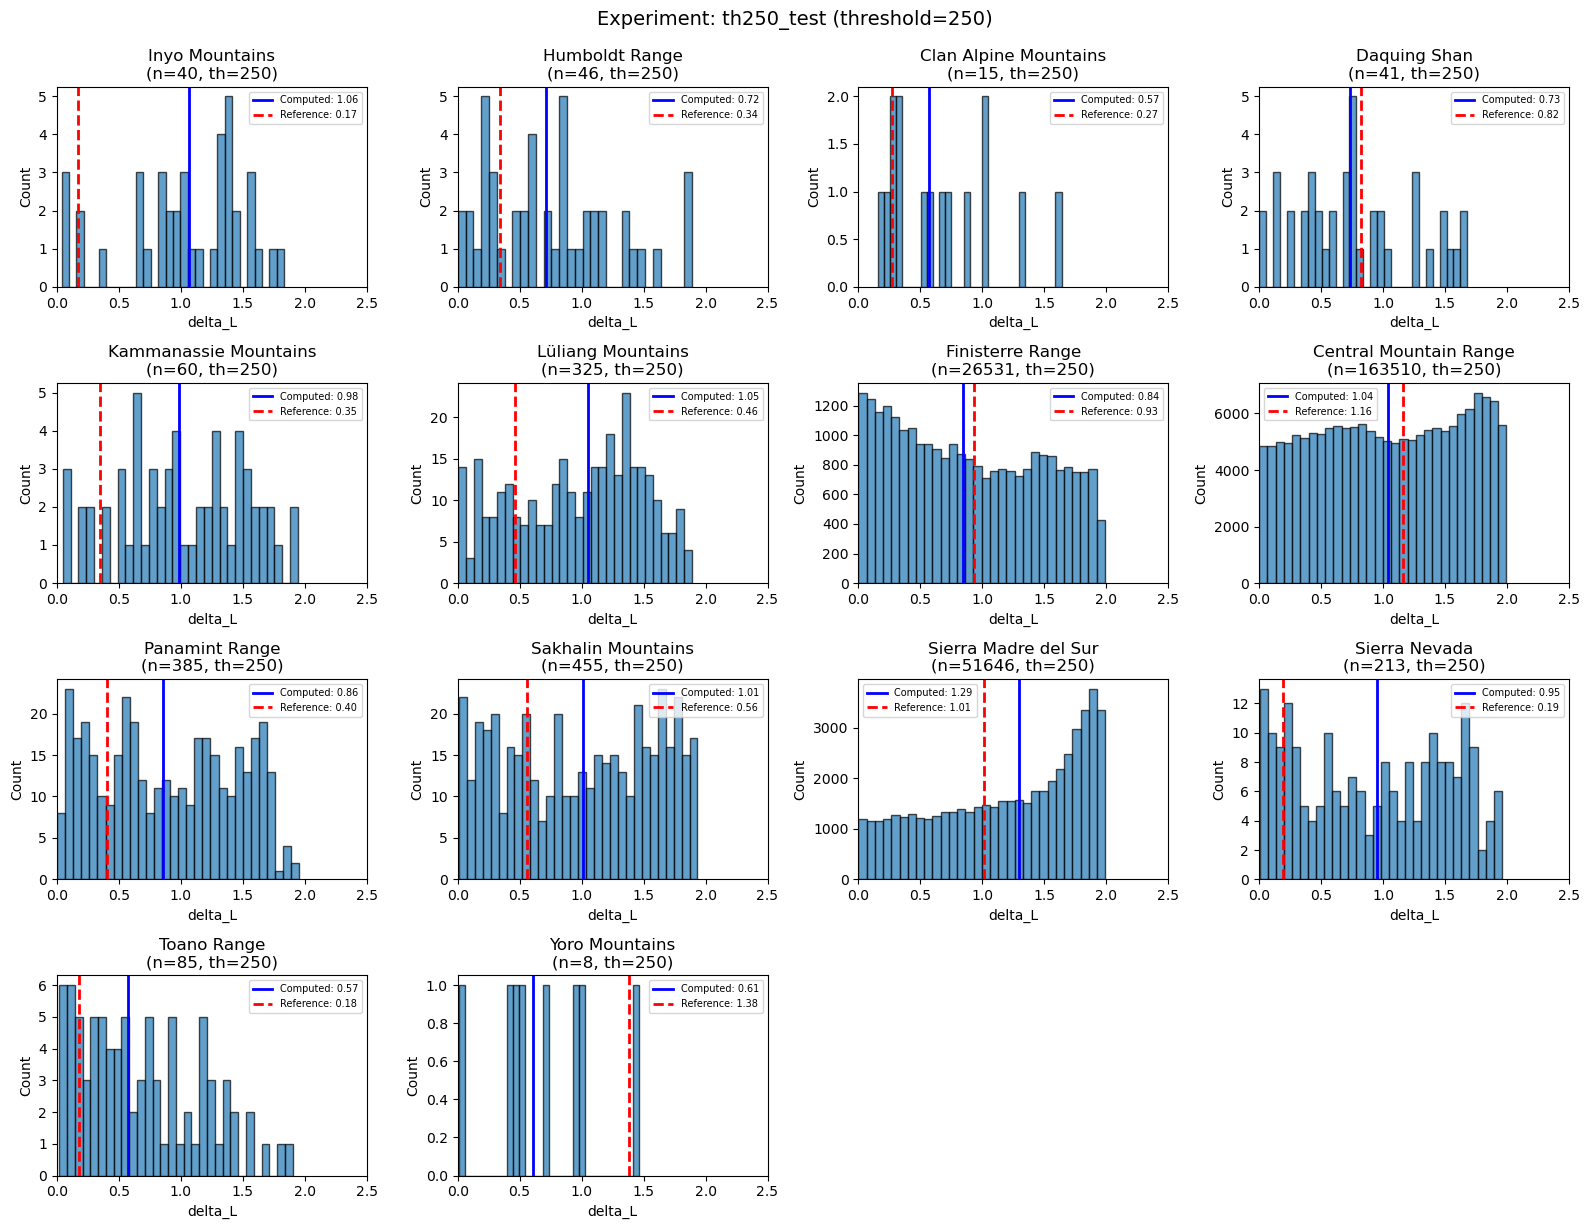

In [7]:
# Plot delta_L distribution for analyzed basins
n_basins = len(basin_results)
if n_basins == 0:
    print("No results to plot")
else:
    n_cols = min(4, n_basins)
    n_rows = (n_basins + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = np.atleast_1d(axes).flatten()
    
    for idx, (basin_name, df) in enumerate(basin_results.items()):
        ax = axes[idx]
        
        if df.empty:
            ax.set_title(f"{basin_name}: No data")
            continue
        
        config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
        ref = get_reference_delta_L(BASINS_TO_ANALYZE[basin_name]["paper_name"])
        
        delta_L = df['delta_L'].dropna()
        stats = compute_asymmetry_statistics(delta_L)
        
        ax.hist(delta_L, bins=30, alpha=0.7, edgecolor='black')
        ax.axvline(stats['median'], color='blue', linestyle='-', linewidth=2, 
                   label=f'Computed: {stats["median"]:.2f}')
        ax.axvline(ref['median'], color='red', linestyle='--', linewidth=2,
                   label=f'Reference: {ref["median"]:.2f}')
        
        ax.set_xlabel('delta_L')
        ax.set_ylabel('Count')
        short_name = config["full_name"].split(',')[0]
        ax.set_title(f"{short_name}\n(n={len(delta_L)}, th={STREAM_THRESHOLD})")
        ax.legend(fontsize=7)
        ax.set_xlim(0, 2.5)
    
    # Hide unused subplots
    for idx in range(len(basin_results), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle(f'Experiment: {EXPERIMENT_NAME} (threshold={STREAM_THRESHOLD})', y=1.02, fontsize=14)
    
    # Save figure
    fig.savefig(OUTPUT_DIR / "delta_L_distribution.png", dpi=150, bbox_inches='tight')
    print(f"Saved figure to: {OUTPUT_DIR / 'delta_L_distribution.png'}")
    plt.show()

---
## Export Combined Results

In [8]:
# Combine all results
all_results = []
for basin_name, df in basin_results.items():
    if df.empty:
        continue
    df_copy = df.copy()
    df_copy['basin'] = basin_name
    config = get_basin_config(BASINS_TO_ANALYZE[basin_name]["paper_name"])
    df_copy['basin_full_name'] = config['full_name']
    df_copy['stream_threshold'] = STREAM_THRESHOLD
    df_copy['experiment'] = EXPERIMENT_NAME
    all_results.append(df_copy)

if all_results:
    df_all = pd.concat(all_results, ignore_index=True)
    
    combined_path = OUTPUT_DIR / "all_basins_combined.csv"
    df_all.to_csv(combined_path, index=False)
    
    print(f"\nCombined results saved to: {combined_path}")
    print(f"Total pairs: {len(df_all)}")
    print(f"Total touching: {df_all['touching'].sum()}")
    print(f"Basins: {df_all['basin'].nunique()}")
else:
    print("No results to combine")


Combined results saved to: /Users/guypi/Projects/channel-heads/data/outputs/experiments/th250_test/all_basins_combined.csv
Total pairs: 243360
Total touching: 3348
Basins: 14


---
## Experiment Complete

Results have been saved to the experiment output directory. To compare with other experiments:

```python
# Load results from different experiments
import pandas as pd
from channel_heads import get_experiment_output_dir

df_th145 = pd.read_csv(get_experiment_output_dir("th145_baseline") / "all_basins_combined.csv")
df_th500 = pd.read_csv(get_experiment_output_dir("th500_test") / "all_basins_combined.csv")

# Compare delta_L distributions
print(f"Threshold 145: median delta_L = {df_th145['delta_L'].median():.3f}")
print(f"Threshold 500: median delta_L = {df_th500['delta_L'].median():.3f}")
```